In [6]:
library(brms)
library(tidyverse)
library(feather)
library(betareg)
library(rstanarm)
library(bayesplot)
df <- read_feather("../results_Jerry/gain_distance.feather") %>%
  mutate(Deposition=factor(Deposition)) %>%
  select(-c(`Azimuth mod 180`, `Fraction of wells`))

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())


Attaching package: ‘rstanarm’


The following objects are masked from ‘package:brms’:

    dirichlet, exponential, get_y, lasso, ngrps


This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting



In [3]:
summary(df)

   Injector           Producer              Gain               Tau       
 Length:239         Length:239         Min.   :0.001373   Min.   :127.0  
 Class :character   Class :character   1st Qu.:0.016291   1st Qu.:367.8  
 Mode  :character   Mode  :character   Median :0.031848   Median :632.4  
                                       Mean   :0.048471   Mean   :577.3  
                                       3rd Qu.:0.065862   3rd Qu.:743.1  
                                       Max.   :0.221238   Max.   :957.5  
                                                                         
 Interwell Distance (m)             Deposition      angle         
 Min.   :  101          Flood Tidal Delta:117   Min.   :-3.13256  
 1st Qu.: 1056          Shoreface        : 52   1st Qu.:-1.84296  
 Median : 2816          Tidal Channel    : 70   Median :-0.05869  
 Mean   : 2830                                  Mean   :-0.15431  
 3rd Qu.: 4022                                  3rd Qu.: 1.27298  
 Max. 

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


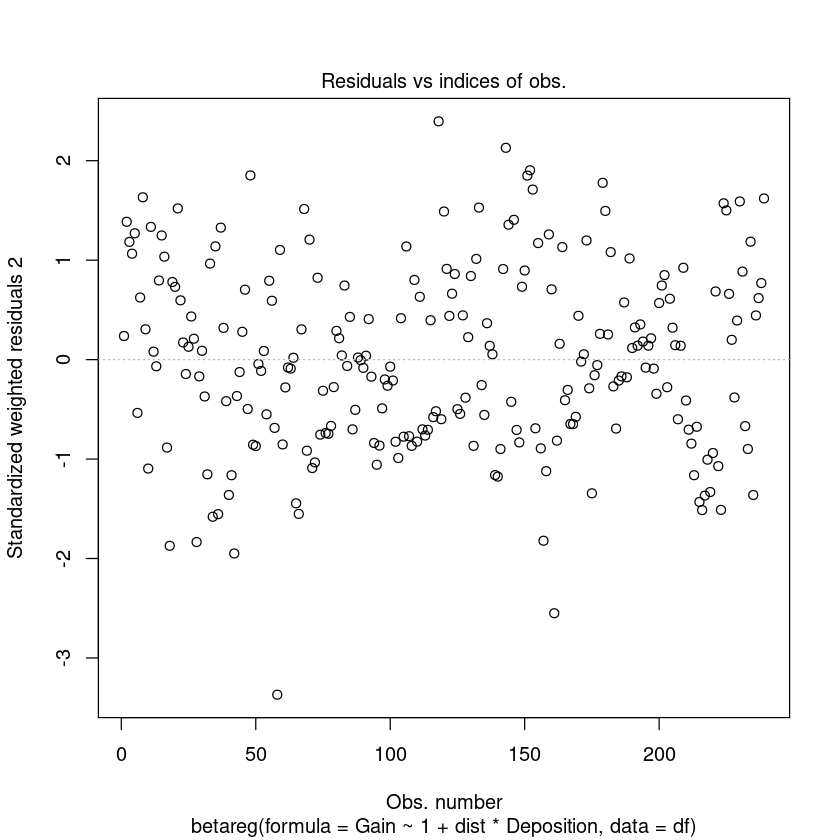

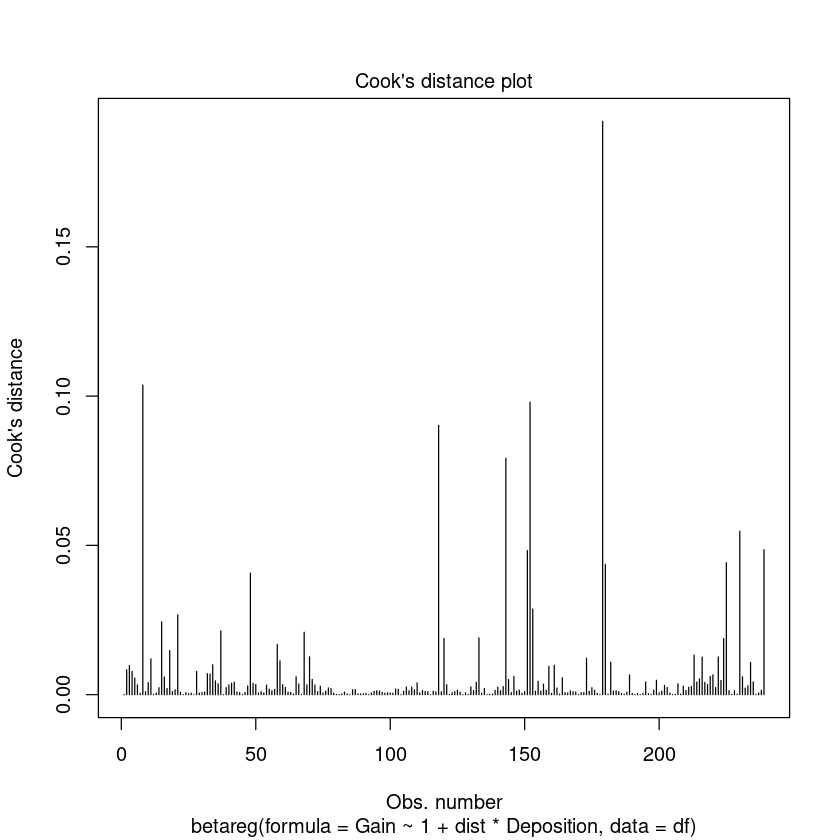

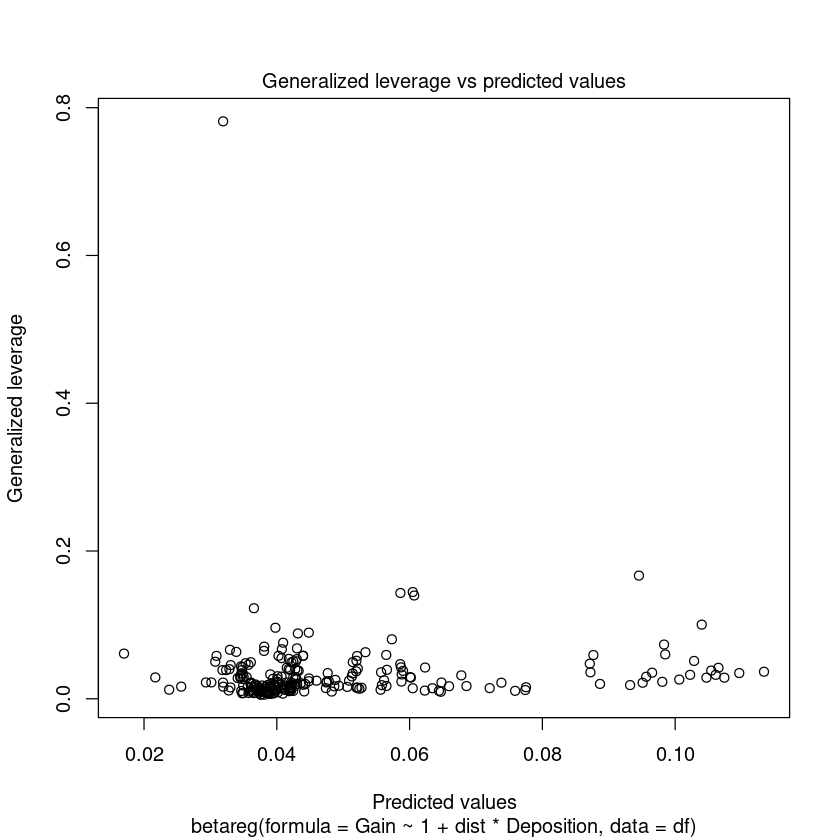


Call:
betareg(formula = Gain ~ 1 + dist * Deposition, data = df)

Standardized weighted residuals 2:
    Min      1Q  Median      3Q     Max 
-3.3690 -0.6972 -0.0441  0.6943  2.3960 

Coefficients (mean model with logit link):
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -3.056e+00  1.499e-01 -20.381  < 2e-16 ***
dist                         -1.649e-04  1.275e-04  -1.294    0.196    
DepositionShoreface           3.872e-01  2.465e-01   1.571    0.116    
DepositionTidal Channel       1.401e+00  2.217e-01   6.319 2.63e-10 ***
dist:DepositionShoreface     -9.394e-05  2.106e-04  -0.446    0.655    
dist:DepositionTidal Channel -1.017e-03  2.227e-04  -4.567 4.95e-06 ***

Phi coefficients (precision model with identity link):
      Estimate Std. Error z value Pr(>|z|)    
(phi)   39.476      3.779   10.45   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Type of estimator: ML (maximum likelihood)
Log-li

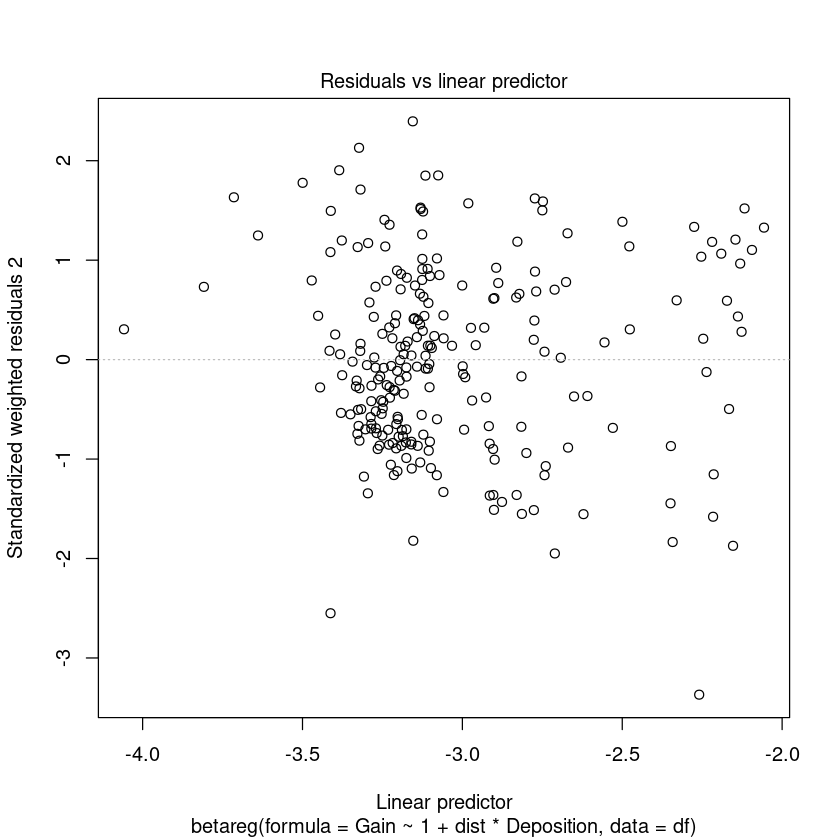

In [8]:
model.glm <- glm(Gain ~ dist * Deposition, data=df, family=binomial(lin="logit"))
#summary(model.glm)

reg <- betareg(Gain ~ 1 + dist * Deposition , data=df)
x_pred <- data.frame(dist=rep(0:3000, each=3), Deposition=factor(rep(c("Flood Tidal Delta","Shoreface","Tidal Channel"))))
df_preds <- data.frame(Gain=predict(reg, x_pred), dist=x_pred$dist, Deposition=x_pred$Deposition)
plot(reg)
summary(reg)

In [13]:
model <- stan_betareg(Gain ~ dist * Deposition, data=df, link = "logit", link.phi = "identity",
                     cores = 2, seed=42)
summary(model, digits=5, probs=c(0.03,0.5,0.97))


Model Info:
 function:     stan_betareg
 family:       beta [logit, link.phi=identity]
 formula:      Gain ~ dist * Deposition
 algorithm:    sampling
 sample:       4000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 239

Estimates:
                               mean     sd       3%       50%      97%   
(Intercept)                  -2.83208  0.19346 -3.20735 -2.82721 -2.47043
dist                         -0.00013  0.00016 -0.00045 -0.00013  0.00018
DepositionShoreface           0.32000  0.31170 -0.28341  0.32518  0.90855
DepositionTidal Channel       1.16730  0.29266  0.60754  1.17246  1.72550
dist:DepositionShoreface     -0.00008  0.00026 -0.00057 -0.00009  0.00042
dist:DepositionTidal Channel -0.00084  0.00029 -0.00139 -0.00084 -0.00030
(phi)_(Intercept)            18.53326  1.45683 15.88452 18.49581 21.31815

Fit Diagnostics:
           mean      sd        3%        50%       97%    
mean_PPD 460.93468   2.01825 456.49024 461.21666 463.83693
mean

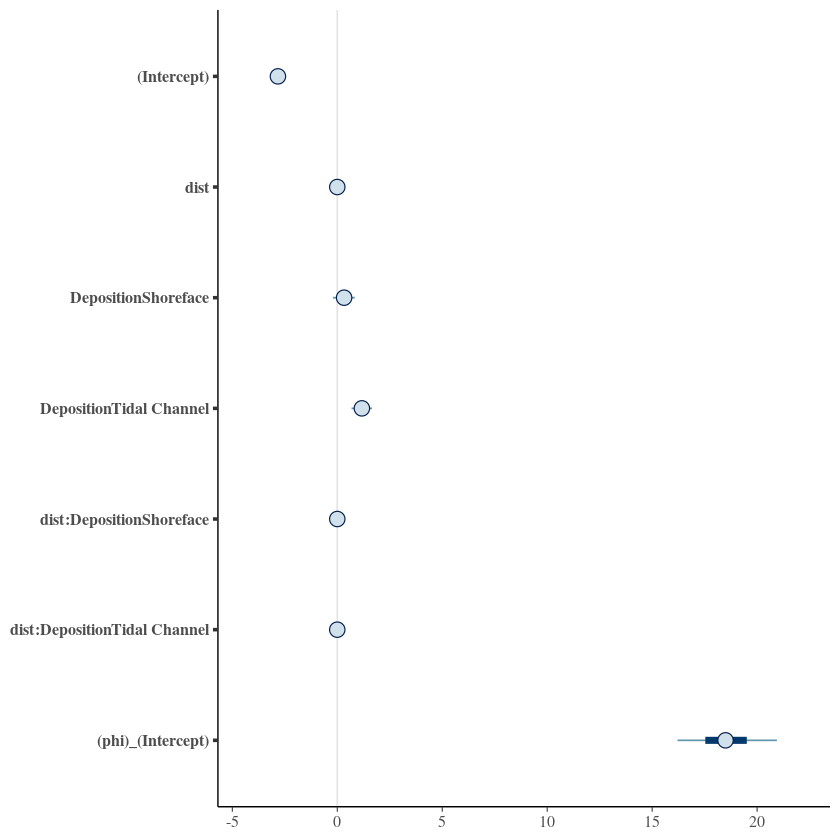

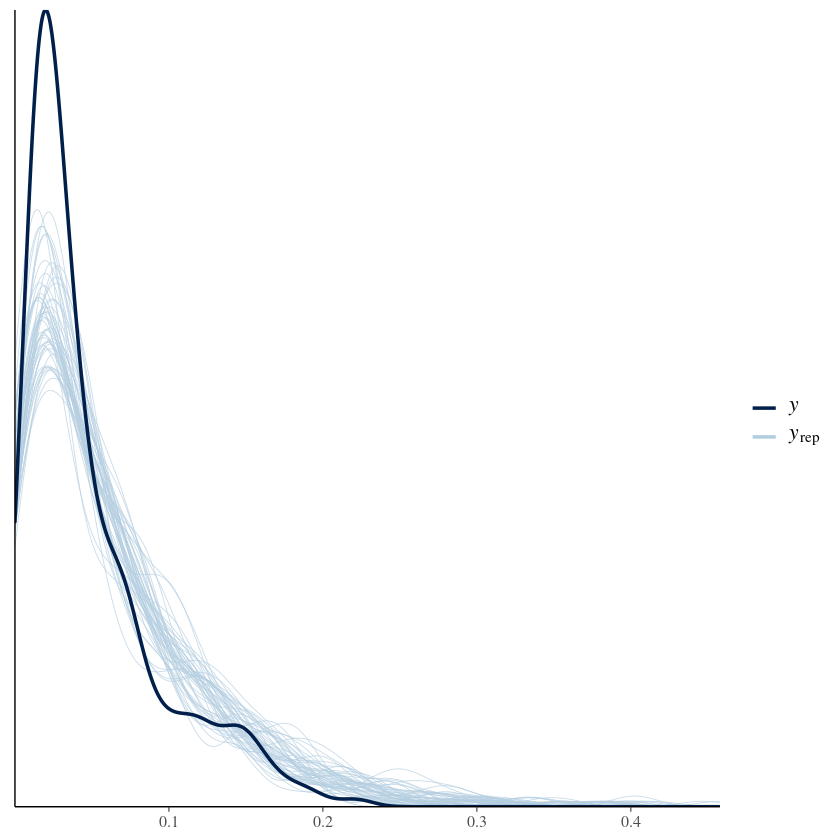

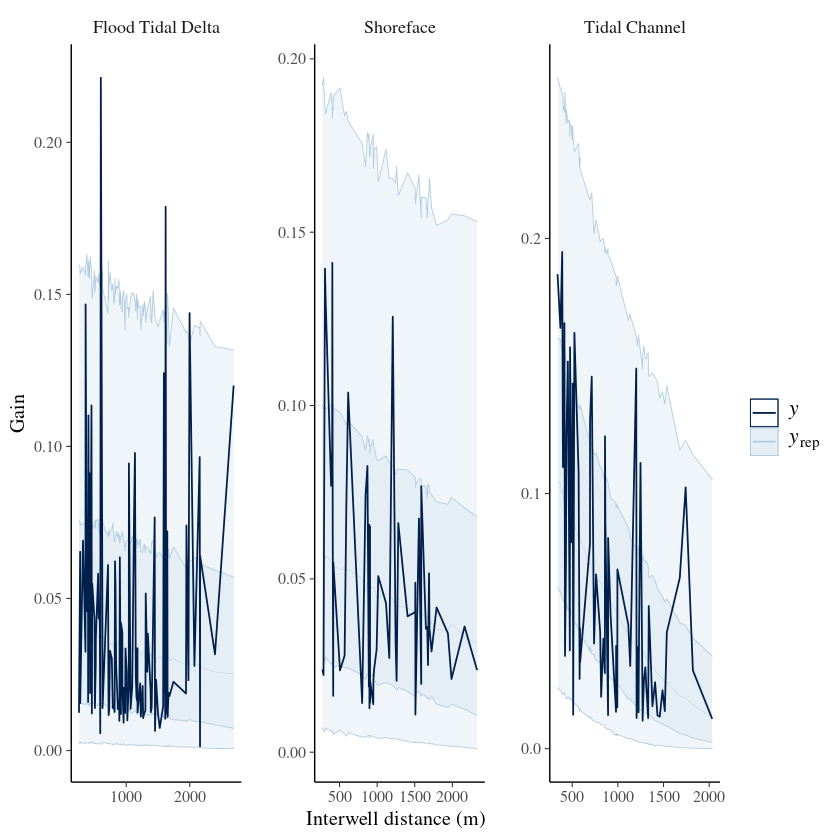

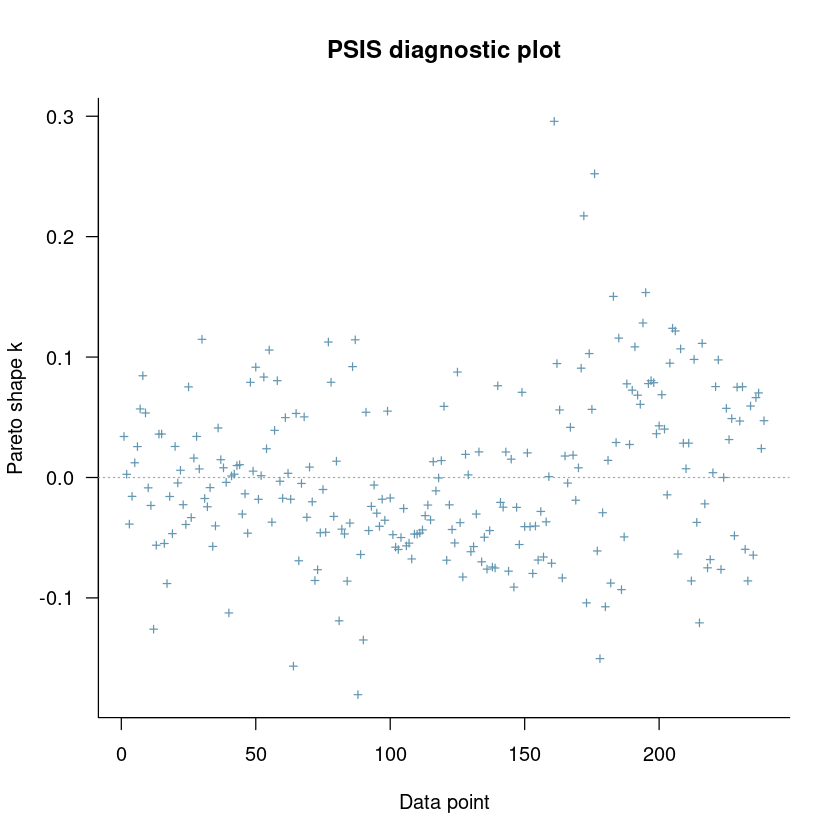

In [11]:
plot(model)
pp_check(model)
ppc_ribbon_grouped(
  y=df$Gain,
  yrep= posterior_predict(model),
  x=df$dist,
  group=df$Deposition,
  prob=0.5
) +
  labs(x="Interwell distance (m)", y="Gain")
plot(loo(model))

In [15]:
launch_shinystan(model)



Hang on... preparing graphical posterior predictive checks for rstanarm model.
See help('shinystan', 'rstanarm') for how to disable this feature.


Launching ShinyStan interface... for large models this  may take some time.


Listening on http://127.0.0.1:4422



NULL
NULL


`geom_smooth()` using formula 'y ~ x'

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
`geom_smooth()` using formula 'y ~ x'

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


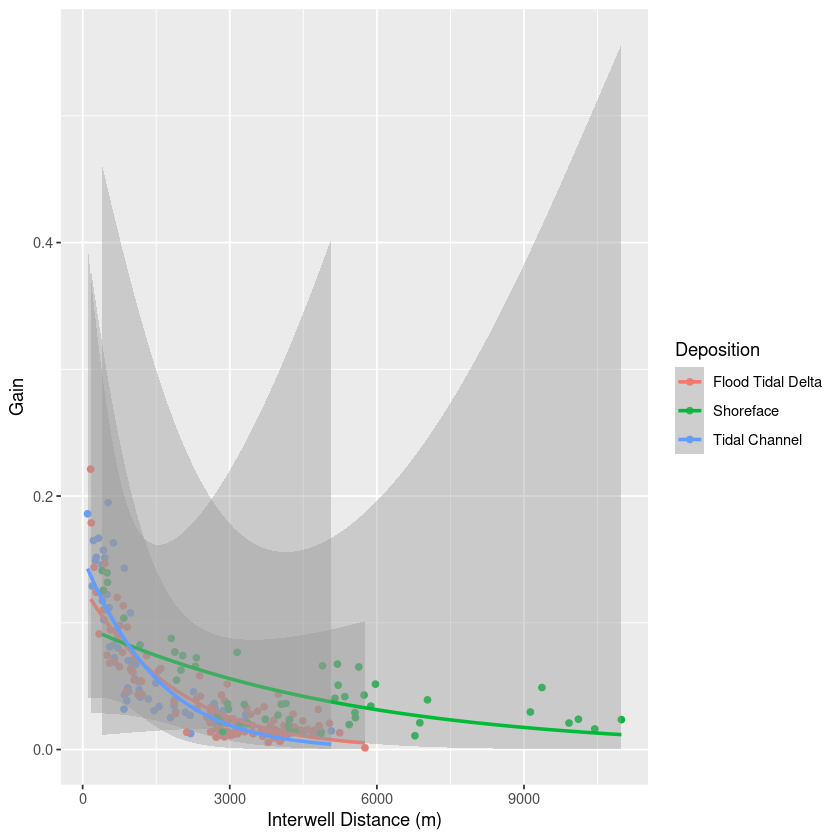

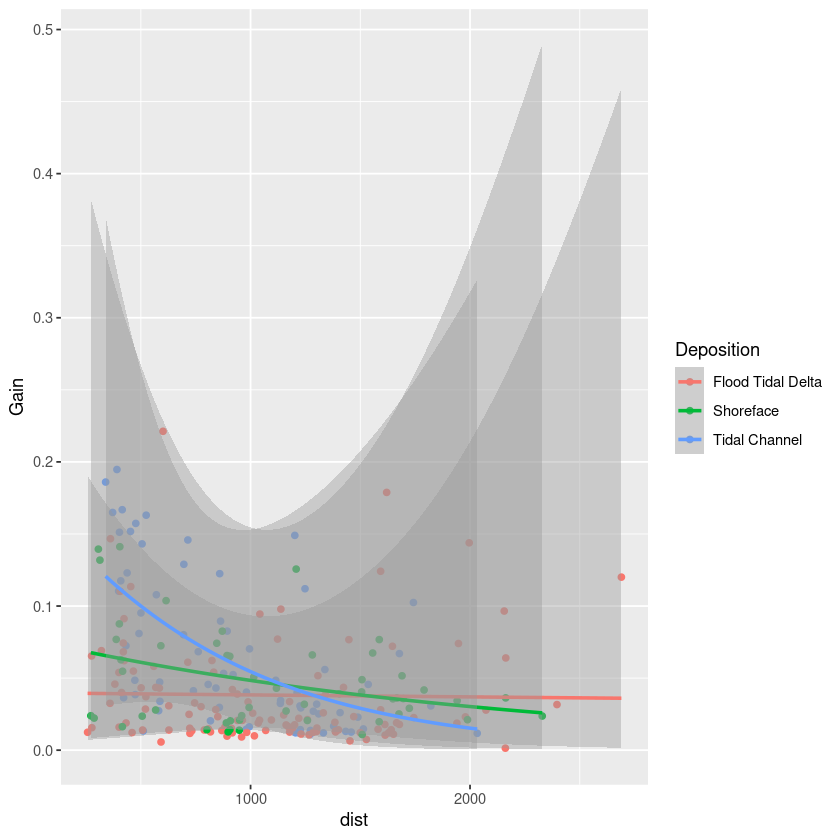

In [4]:
ggplot(df, aes(`Interwell Distance (m)`, Gain, color=Deposition)) +
  geom_point() +
  geom_smooth(method="glm", method.args = list(family = "binomial"))

ggplot(df, aes(dist, Gain, color=Deposition)) +
  geom_point() +
  geom_smooth(method="glm", method.args = list(family = "binomial"))